# Custom logistic regression algorithm

# Abstract
In this we write a custom logistic regression machine learning algorithm from scratch using numpy and pandas. The algorithm will be able to take in an a dataset with an unspecificed number of features ($X_n$ where $n=0,1,...N$) and indices ($m=0,1,...M$) as well as a target feature ($y$) which is either true (1) or false (0). The code will be able to generate polynomial combinations of each feature $X_0^{1}, X_0^{2}, ... X_0^{d}, X_1^1, ...X_N^{d-1},X_N^{d}$. The code will feature reparameterisation that can be used to remedy overfitting. The code will not feature a custom learning rate ($\alpha$), instead convergence of the model for a given learning rate can be determined by plotting the cost function as the gradient descent function iterates. In this notebook, I will write each sub-function of the logistic regression algorithm, testing correctness on a small datasets as outlined in the contents. The code is also fully vectorised (with respect to performing summations over the dataset). 

There are many improvements that could be made to this code, such as mixed polynomial features ($X_0^{d_0} X_1^{d_1} ... X_N^{d_N}). However, as this was a learning task I have decided to move on to new projects.


After the algorithm is complete, in a separate notebook, I will input a full dataset using the algorithm to determine the likelihood of someone having chronic kidney disease (CKD). By tuning the parameters of the algorithm we will tailor the program to pick up all true positives at an acceptable amount of false positives - as this type of diagnosis is a precursor to a more invasive procedure.   

# Contents
<ul>
    <li>Calculate cost<ul><li>Data visualisation</li><li>Using cost to compare good and bad fits</li></ul></li>
    <li>Gradient descent to minimise cost<ul><li>Learning rate and convergence</li></ul></li>
    <li>Logistic regression with two features<ul><li>Comparing trained decision boundary to human attempt</li></ul></li>
    <li>Logistic regression with several features</li>
    <li>Polynomial features<ul><li>Min-max scaling</li><li>Visualising polynomial decision boundaries</li><li>Convergence of higher polynomial features</li><li>Reducing cost with higher order features</li></ul></li>
    <li>Overfitting and reparameterisation</li>
</ul>

# Calculate cost
### Data visualisation

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Import dataset containing a several anonomous features and a target feature. This dataset was obtained as an example dataset from udemy course: Python for Data Science and Machine Learning Bootcamp - Udemy - Section 18: Lecture 96. 

In [2]:
df = pd.read_csv("Classified Data",index_col=0)
#Reduce dataset to two features
df.drop(labels="PTI SBI LQE QWG FDJ PJF WTT NXJ".split(),axis=1,inplace=True)

Features are $X_0$ = "EQW" and $X_1$ = "HQE" which are meant to demonstrate classified data. The values of these features have already been approprietely scaled for logistic regression. The target class is $y$ = "TARGET CLASS". Our data has 1000 examples or indices.

In [3]:
df.head(3)

,EQW,HQE,TARGET CLASS
0,0.567946,0.879422,1
1,0.535342,0.621552,0
2,0.921990,0.957877,0


In [4]:
len(df.index)

1000

### Using cost to compare good and bad fits

We see that the dataset shows a relatively clear trend regarding the features "HQE" and "EQW" with regard to the "TARGET CLASS". We see that there is a reasonable amount of overlap, if I attempt to draw a reasonable decision boundary (blue solid line) I can get appromitely 80-90% of the target class' correct. I also draw a bad decision boundary (red dashed line). Therefore, we predict that the baseline performance for this reduced dataset is about 90%. A machine learning algoirthm should not perform too much better than this. 

(0.0, 1.6, 0.0, 2.0)

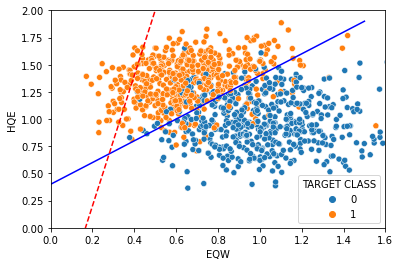

In [5]:
grid = sns.scatterplot(x="EQW",y="HQE",hue="TARGET CLASS",data=df)
##My attempt at a regression line: X_1 = X_0 + 0.4
plt.plot([0., 1.5],[0.4, 1.9],'b-')
##Bad attempt at a regression line: X_1 = 6X_0 -1
plt.plot([0., 1.5],[-1, 8],'r--')
plt.axis([0, 1.6, 0, 2])

For logistic regression we need the sigmoid function. This function should be able to take in a numpy array of variables and return an element-wise application of the sigmoid function.

In [6]:
def sigmoid(z):
    '''
    Applies the sigmoid function to every element in input matrix/vector. 
    Parameters:
    ----------
    Input: z - numpy.ndarray of shape (N,)
    Output: g(z) - np.ndarray of shape (N,) - sigmoid function applied to each element of z
    '''
    g = 1 / (1 + np.exp(-z))
    return g

In [7]:
#Example:
sigmoid_example = sigmoid(np.array([-100,0.8,-0.2,5]))
sigmoid_example

array([3.72007598e-44, 6.89974481e-01, 4.50166003e-01, 9.93307149e-01])

In [8]:
type(sigmoid_example)

numpy.ndarray

In [9]:
sigmoid(sigmoid_example).shape

(4,)

Using the sigmoid function we can calculate the cost of a certain model to our data. Using logistic regression model, the likelihood of example or index having "TARGET CLASS" equal to 1 is f_wb. For a given model quantified with model parameters W and b, the cost function quantifies how close the predicted target class' (y_hat) are to the target class' (y). The larger the cost, the worse the model fits. 

In [10]:
def calc_cost(X, y, W, b, lambda_):
    '''
    Calculates the cost function for a model applied to input features. The lower the cost, the better the model fits.
    The cost function can punish large parameter values for the model if reparameterisation (lambda_ != 0) is included.
    To get the true cost function of the data, do not include reparameterisation (lambda_ == 0).
    Parameters:
    ----------
    Input: X - pandas.core.frame.DataFrame shape (M,N) - features of dataset with M indices and N features
           y - pandas.core.frame.DataFrame shape (M,1) - target class of dataset with M indices
           W - numpy.ndarray of shape (N,) - feature parameters for model
           b - float - offset parameter for model
           lambda_ - float - reparameterisation parameter
    Output: cost - float - cost function of model with parameter W and b fitted to true data y with features X
    '''
    M = len(X.index)
    f_wb_vec = sigmoid(np.matmul(X.to_numpy(),W) + b)
    
    #Overflow issues with upcoming log's if entries are too close to zero or one
    f_wb_vec[f_wb_vec<1e-15]=1e-15
    f_wb_vec[1-f_wb_vec<1e-15]=1-1e-15
    
    loss_vec = -y.to_numpy().reshape(M,1)*np.log(f_wb_vec) - (1-y.to_numpy().reshape(M,1))*np.log(1 - f_wb_vec)

    
    cost = (sum(loss_vec)/M + (lambda_/(2*M))*np.sum(W*W))[0]
    return cost

In [11]:
loss_vec = np.zeros((10,1))
loss_vec[2,0] = 2
loss_vec[:,0]

array([0., 0., 2., 0., 0., 0., 0., 0., 0., 0.])

Lets demonstrate cost with the two models sketched in the above graph. The decision boundary marks the line that separates y_hat = 0 and 1. The bad model has the form W = np.array([-6, 1]) and b = 1.

In [12]:
X = df.drop("TARGET CLASS",axis=1)
y = df["TARGET CLASS"]
W_bad = np.array([-6,1]).reshape((2, 1))
b_bad = 1
cost_bad = calc_cost(X, y, W_bad, b_bad, lambda_=0.)
print("The cost of a bad fit: {}".format(cost_bad))

The cost of a bad fit: 0.9704234643449147


Now we demonstrate lower cost of the better fit with mode W = np.array([-1, 1]) and b = -0.4.

In [13]:
W_good = np.array([-1,1]).reshape((2, 1))
b_good = -0.4
cost_good = calc_cost(X, y, W_good, b_good, lambda_=0.)
cost_good
print("The cost of a good fit: {}".format(cost_good))

The cost of a good fit: 0.5398679545726451


# Gradient descent to minimise cost

In order to implament gradient descent, to find the best model to fit our data, we need a function that calculates the partial derivative of the gradient of the cost function with respect to the parameters of our model (elements of W and b). 

In [14]:
def compute_gradient(X, y, W, b, lambda_):
    '''
    Computes the partial derivatives of the cost function with respect to model parameters.
    Parameters:
    ----------
    Input: X - pandas.core.frame.DataFrame shape (M,N) - features of dataset with M indices and N features
           y - pandas.core.frame.DataFrame shape (M,1) - target class of dataset with M indices
           W - numpy.ndarray of shape (N,1) - feature parameters for model
           b - float - offset parameter for model
           lambda_ - float - reparameterisation parameter
    Output:dj_db - float - partial derivative of cost function with respect to model parameter b
           dj_dW - numpy.ndarray of shape (N,1) - partial derivative of cost function wwith respect to model parameters in vector W
    '''
    (M,N) = X.shape
    dj_dW = np.array(np.zeros(N)).reshape(N,1)
    dj_db = 0.0
    
    f_wb_vec = sigmoid(np.matmul(X.to_numpy(),W) + b)
    dj_dW_vec = X.to_numpy()*(f_wb_vec - y.to_numpy().reshape(M,1))
    dj_db_vec = (f_wb_vec - y.to_numpy().reshape(M,1))
    dj_dW = np.sum(dj_dW_vec,axis=0).reshape(N,1)/M + lambda_*W/M
    dj_db = np.sum(dj_db_vec,axis=0)/M
    
    return dj_db, dj_dW

This function does not lend itself to an example so lets move on to the full gradient descent function.

The gradient descent function takes in an initial model W_init and b_init as well as the data and other parameters and using gradient descent to find minima in the N-dimensional cost function.  

In [15]:
def gradient_descent(X, y, W_init, b_init, lambda_, alpha=1, max_iter=100, print_step=20, save_step=10):
    '''
    Perform gradient descent algorithm to minimise cost function by changing the model parameters.
    Parameters:
    ----------
    Input: X - pandas.core.frame.DataFrame shape (M,N) - features of dataset with M indices and N features
           y - pandas.core.frame.DataFrame shape (M,1) - target class of dataset with M indices
           W_init - numpy.ndarray shape (N,1) - initial feature parameters for model
           b_init - float - initial offset parameter for model
           alpha - float - learning rate of gradient descent
           max_iter - int - maximum number of iterations for gradient descent
           print_step - int - on iterations that are a multiple of print_step, print percentage of completion. If False do not print progress
           save_step - int - on iterations that are a multiple of save_step, store cost, models parameters and iterations in to vectors. If False only save last iteration
           lambda_ - float - reparameterisation parameter
    Output:iter_history - numpy.array - saved iterations for each multiple of save_step in max_iter 
           cost_reg_history - numpy.ndarray - cost function at saved iterations
           W - numpy.ndarray shape (N,1) - final model parameters
           b - float - final offset model parameter
           final_cost - float - final cost function of dataset (true cost does not use reparameterisation term) 
    '''
    
    #Initialisations
    cost_reg_history, iter_history, final_cost = [], [], 0.
    W, b = W_init, b_init
    for iter in range(1,max_iter+1):
        dj_db, dj_dW = compute_gradient(X, y, W, b, lambda_)   
        
        W = W - alpha*dj_dW
        b = b - alpha*dj_db
        
        
        cost_reg = calc_cost(X, y, W, b, lambda_)
        
        if(save_step!=0):
            if(iter % save_step or save_step==1):
                cost_reg_history.append(cost_reg)
                iter_history.append(iter) 
        elif(iter==max_iter):
            cost_reg_history.append(cost_reg)
            iter_history.append(iter) 
                
        if(print_step):
            if(iter % print_step == 0):print("{}%\n".format(100*iter/max_iter))
        
    #Calculate final cost of the model - note that this is the true cost
    #and so does not include reparameterisation (set lambda_=0.)    
    final_cost = calc_cost(X, y, W, b, lambda_=0.)
        
    return cost_reg_history, W, b, iter_history, final_cost

### Learning rate and convergence 

In this function we do not have a way to determine the learning rate. Our learning rate should allow gradient descent to reduce the cost function efficiently as to not waste resources but should be slow enough to ensure we don't miss the minima of the function. Lets test convergence for several different values for alpha in our dataset.

In [16]:
alpha_lst = [.3,1,3]
iterations_history, cost_reg_history = [], []
W_init, b_init = np.ones(2).reshape((2, 1)), 0.
lambda_ = 0.
for alpha_val in alpha_lst:
    cost_reg, dummy_W, dummy_b, iterations, final_cost = gradient_descent(X, y, W_init, b_init, lambda_, alpha=alpha_val, max_iter=500, print_step=False, save_step=1)
    cost_reg_history.append(cost_reg)
    iterations_history = iterations
    print("alpha={} completed.".format(alpha_val))

alpha=0.3 completed.
alpha=1 completed.
alpha=3 completed.


We see that alpha = 0.1 and 0.3 converge too slowly and that alpha = 10 does not converge and skips over the cost function space missing minima. A safe choice seems to be alpha = 1 for 300 iterations. In this algorithm it is best to test convergence for a specific learning rate as we have done here. Writing a program to determine the learning rate and convergence is a tricky task and will not be attempted here. 

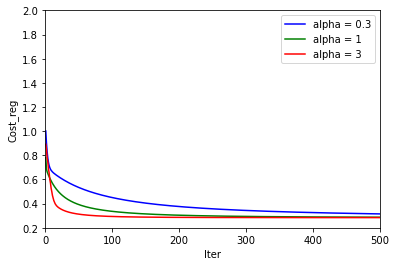

In [17]:
colour = ['b','g','r']
for i in range(len(colour)):
    plt.plot(iterations_history,cost_reg_history[i], color=colour[i], label='alpha = {}'.format(alpha_lst[i]))
plt.ylabel("Cost_reg"), plt.xlabel("Iter")
plt.axis([0, 500, 0.2, 2])
plt.legend()

# Logistic regression with two features

Now we wrap everything in to a final function that trains a model based off of training data and produces estimated solutions to a test dataset.

In [18]:
def logistic_regression(X_train, X_test, y_train, y_test, lambda_, alpha=1, f_cutoff=0.5, max_iter=100, print_step=20):
    '''
    Takes in input training data, uses gradient descent to find an optimal model, applies model to test features.
    After applying model to test features, estimated target class data is obtained which is compared to test target class data.
    Parameters:
    ----------
    Input: X_train - pandas.core.frame.DataFrame - training set features of shape (M_train,N) with M_train indices and N features
           y_train - pandas.core.frame.DataFrame - training set of shape (M_train,1) with target feature for each index
           X_test - pandas.core.frame.DataFrame - training set features of shape (M_test,N) with M_test indices and N features
           y_test - pandas.core.frame.DataFrame - training set of shape (M_test,1) with target feature for each index
           lambda_ - float - reparameterisation parameter
           alpha - float - learning rate of gradient descent
           f_cutoff - float - cutoff for sigmoid function to determine if y_hat is equal to 0 or 1.
           max_iter - int - maximum number of iterations for gradient descent
           print_step - int - on iterations that are a multiple of print_step, print percentage of completion. If False do not print progress
    Output:y_hat - numpy.array - predicted target features of shape (M_train,1) 
           cost_reg_history - numpy.ndarray - cost function at saved iterations
           W_model - numpy.ndarray shape (N,1) - final model parameters
           b_history - float - final offset model parameter
           final_cost - float - final cost function of dataset (true cost does not use reparameterisation term) 
    '''
    N_train = len(X_train.columns)
    W = np.ones(N_train).reshape(N_train,1)
    b = 0.
    cost_reg_history, W_model, b_model, print_steps, train_cost = gradient_descent(X_train, y_train, W, b, lambda_, alpha, max_iter, print_step, save_step=0)

    M_test = len(X_test.index)
    
    f_wb_vec = sigmoid(np.matmul(X_test.to_numpy(),W_model) + b_model)
    f_wb_vec[f_wb_vec >= f_cutoff] = 1
    f_wb_vec[f_wb_vec < f_cutoff] = 0
    
    y_hat = y_test.copy(deep=True)
    y_hat.iloc[:] = np.squeeze(f_wb_vec.reshape(1,M_test))
    
    test_cost = calc_cost(X_test, y_test, W_model, b_model, lambda_=0.)
                       
    return y_hat, W_model, b_model, train_cost, test_cost

Now lets give this function a go with some test data.

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
y_hat, W_model, b_model, train_cost, test_cost = logistic_regression(X_train, X_test, y_train, y_test, lambda_=0., alpha=1, max_iter=500, print_step=False)
print("The train cost is {} and the test cost is {}".format(train_cost, test_cost))

The train cost is 0.27989951141263947 and the test cost is 0.3030401638843334


Because the training cost and test cost are similar it means the data is not overfit! Although it would be hard to overfit considering we only used linear features. Lets see how many of the test set it correctly classified.

In [20]:
sum(y_test==y_hat)/len(y_test)

0.8666666666666667

We correctly classified about 89% of results, this is roughly the expected basline performance that a human could achieve on this dataset.

### Comparing trained decision boundary to human attempt

Lets extract our fit and plot it on our dataset.

In [21]:
print("W = {} and b = {}".format(W_model, b_model))

W = [[-6.32157276]
 [ 6.53585661]] and b = [-2.47916241]


(0.0, 1.6, 0.0, 2.0)

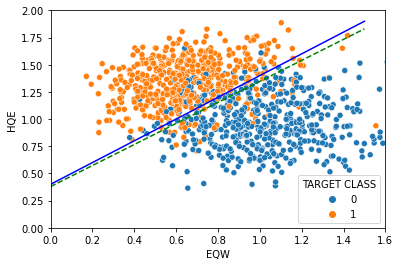

In [22]:
grid = sns.scatterplot(x="EQW",y="HQE",hue="TARGET CLASS",data=df)
##My initial attempt at a regression line: X_1 = X_0 + 0.4
plt.plot([0., 1.5],[0.4, 1.9],'b-')
##Line fitted with own logistic algorithm: X_1 = W[0]*X_0/W[1] + b/W[1]
plt.plot([0., 1.5],[-b_model/W_model[1], (-b_model - 1.5*W_model[0])/W_model[1]],'g--')
plt.axis([0, 1.6, 0, 2])

We can see that the logistic regression algorithm predicted almost the same linear decision boundary as we did - which indicates it is working properly.

Lets see how sklearn performs with the same dataset.

In [23]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
y_hat_sklearn = logmodel.predict(X_test)

In [24]:
sum(y_hat_sklearn == y_test)/len(y_test)

0.8666666666666667

So in this dataset our algorithm performed almost as well as sklearn! We got a correct classififcation of 88% compared to 89% in sklearn. This is a good start since we do not yet generate polynomial features and we pick our regression parameters (for example learning rate and iterations) manually. 

### Logistic regression with several features

Lets test how our results compare when including all features of the dataset. This way we can ensure our model generalises for more than two features.

In [25]:
df = pd.read_csv("Classified Data",index_col=0)
#Reduce to simplified two feature dataset
df.head(3)

,WTT,PTI,EQW,SBI,LQE,QWG,FDJ,PJF,HQE,NXJ,TARGET CLASS
0,0.913917,1.162073,0.567946,0.755464,0.780862,0.352608,0.759697,0.643798,0.879422,1.231409,1
1,0.635632,1.003722,0.535342,0.825645,0.924109,0.648450,0.675334,1.013546,0.621552,1.492702,0
2,0.721360,1.201493,0.921990,0.855595,1.526629,0.720781,1.626351,1.154483,0.957877,1.285597,0


In [26]:
X = df.drop(labels="TARGET CLASS", axis=1)
y = df["TARGET CLASS"]

Lets test convergence for the full dataset.

In [27]:
alpha_lst = [.1, .3, 1, 3]
iterations_history, cost_reg_history = [], []
N = len(X.columns)
W_init, b_init = np.ones(N).reshape(N,1), 0.
lambda_ = 0.
for alpha_val in alpha_lst:
    cost_reg, dummy_W, dummy_b, iterations, final_cost = gradient_descent(X, y, W_init, b_init, lambda_, alpha=alpha_val, max_iter=500, print_step=False, save_step=1)
    cost_reg_history.append(cost_reg)
    iterations_history = iterations
    print("alpha={} complete.".format(alpha_val))

alpha=0.1 complete.
alpha=0.3 complete.
alpha=1 complete.
alpha=3 complete.


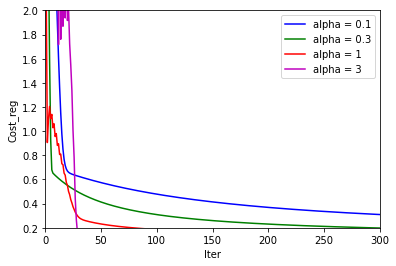

In [28]:
colour = ['b','g','r','m']
for i in range(len(colour)):
    plt.plot(iterations_history,cost_reg_history[i], color=colour[i], label='alpha = {}'.format(alpha_lst[i]))
plt.ylabel("Cost_reg"), plt.xlabel("Iter")
plt.axis([0, 300, 0.2, 2])
plt.legend()

A good choice seems to be alpha = 0.3 with max_iter just over 300, so maybe 500.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
y_hat, W_model, b_model, train_cost, test_cost = logistic_regression(X_train, X_test, y_train, y_test, lambda_=0., alpha=.3, max_iter=500, print_step=False)
print("The train cost is {} and the test cost is {}".format(train_cost, test_cost))

The train cost is 0.16308769059995795 and the test cost is 0.1833376767886156


In [30]:
sum(y_hat == y_test)/len(y_test)

0.9233333333333333

In [31]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
y_hat_sklearn = logmodel.predict(X_test)

In [32]:
sum(y_hat_sklearn == y_test)/len(y_test)

0.9266666666666666

We got even better with more data, implying our logistic regression model works well for larger dataset with more than two features! We now have an algorithm that fits almost as well as sklearn.

# Polynomial features
To test polynomial features we will import a new dataset and focus on two of the features.

In [83]:
from sklearn.datasets import load_wine
wine = load_wine()

In [84]:
df_wine = pd.DataFrame(data=np.c_[wine["data"], wine["target"]],columns=wine["feature_names"]+["target"])
#The wine dataset actually has three values for its target class - 
#we only want two for logistic regression
df_wine = df_wine[df_wine["target"]!=2]

In [85]:
df_wine_reduced = df_wine[["hue","ash","target"]]

### Min-max scaling

Before we calculate polynomial features we need to scale our features.

In [86]:
def min_max_scale(X):
    '''
    Applies min max scaling to input features.
    Parameters:
    ----------
    Input: X - pandas.core.frame.DataFrame - features of shape (M,N) with M indices and N features
    Output: X_minmax - pandas.core.frame.DataFrame - minmax scaled features of shape (M,N) with M indices and N features
    '''
    N = len(X.columns)
    X_minmax = X.copy(deep=True)
    for n in range(N):
        X_minmax.iloc[:,n] =  (X.iloc[:,n] - min(X.iloc[:,n]))/(max(X.iloc[:,n]) - min(X.iloc[:,n]))
    return X_minmax

In [87]:
X = df_wine_reduced[["hue","ash"]]
y = df_wine_reduced["target"]
X_minmax = min_max_scale(X)
X_minmax.head(3)

,hue,ash
0,0.343137,0.572193
1,0.352941,0.417112
2,0.333333,0.700535


### Visualising polynomial decision boundaries

We seet that this data lends itself to a non-linear decision boundary (see my attempt at a fit with the green dashed line). Lets extend our algorithm to include polynomial features and see if we can improve our model.

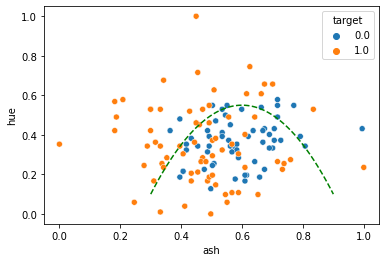

In [88]:
sns.scatterplot(x=X_minmax["ash"],y=X_minmax["hue"],hue=df_wine_reduced["target"])
hue_vec = np.linspace(0.3,0.9,100)
alcalinity_vec = -5*(hue_vec-0.6)**2+0.55
plt.plot(hue_vec,alcalinity_vec,'g--')

I suspect this dataset could benefit from a higher order polynomial decision boundary such as the quadratic one sketched. We can generate these features with the below function. 

In [102]:
def encode_polynomial(X, degree=1):
    '''
    Calculate polynomial features from input features.
    Parameters:
    ----------
    Input: X - pandas.core.frame.DataFrame - features of shape (M,N) with M indices and N features
           degree - float - maximum exponent applied to each feature
    Output: X_poly - pandas.core.frame.DataFrame - polynomial features of shape (M,N*degree) with M indices and N*degree features
    '''
    N = len(X.columns)
    N_poly = N*degree
    
    X_poly = X.copy(deep=True)

    for n in range(0,N):
        for d in range(1,degree+1):
            feat_label = "{}^{},".format(X.columns[n],d)
            #X_poly[feat_label] = X.iloc[:,n]**d
            
            new_feat = X.iloc[:,n].copy(deep=True)
            new_feat = new_feat**degree
            new_feat.rename(index=feat_label, inplace=True)
            X_poly = pd.concat([X_poly, new_feat], axis=1)
    X_poly.drop(labels=X.columns,axis=1,inplace=True)    
    
    return X_poly

For example:

In [103]:
X_poly = encode_polynomial(X_minmax,degree=3)
X_poly.head(3)

,"hue^1,","hue^2,","hue^3,","ash^1,","ash^2,","ash^3,"
0,0.040402,0.040402,0.040402,0.187338,0.187338,0.187338
1,0.043965,0.043965,0.043965,0.072570,0.072570,0.072570
2,0.037037,0.037037,0.037037,0.343787,0.343787,0.343787


We see that alpha = 0.3 is a good value and that 100 iterations is enough for convergence.

We are now going to implement polynomial features in to the logistic regression function.

In [197]:
def logistic_regression(X_train, X_test, y_train, y_test, lambda_, alpha=1, f_cutoff=0.5, degree=1, max_iter=100, print_step=20):
    '''
    Takes in input training data, uses gradient descent to find an optimal model, applies model to test features.
    After applying model to test features, estimated target class data is obtained which is compared to test target class data.
    Parameters:
    ----------
    Input: X_train - pandas.core.frame.DataFrame - training set features of shape (M_train,N) with M_train indices and N features
           y_train - pandas.core.frame.DataFrame - training set of shape (M_train,1) with target feature for each index
           X_test - pandas.core.frame.DataFrame - training set features of shape (M_test,N) with M_test indices and N features
           y_test - pandas.core.frame.DataFrame - training set of shape (M_test,1) with target feature for each index
           lambda_ - float - reparameterisation parameter
           alpha - float - learning rate of gradient descent
           f_cutoff - float - cutoff for sigmoid function to determine if y_hat is equal to 0 or 1.
           degree - int - powers of input features
           max_iter - int - maximum number of iterations for gradient descent
           print_step - int - on iterations that are a multiple of print_step, print percentage of completion. If False do not print progress
    Output:y_hat - numpy.array - predicted target features of shape (M_train,1) 
           cost_reg_history - numpy.ndarray - cost function at saved iterations
           W_model - numpy.ndarray shape (N,1) - final model parameters
           b_history - float - final offset model parameter
           final_cost - float - final cost function of dataset (true cost does not use reparameterisation term) 
    '''
    X_train = encode_polynomial(X_train,degree)
    X_train = min_max_scale(X_train)
    
    X_test = encode_polynomial(X_test,degree)
    X_test = min_max_scale(X_test)
    
    N_train = len(X_train.columns)
    W = np.ones(N_train).reshape(N_train,1)
    b = 0.
    cost_reg_history, W_model, b_model, print_steps, train_cost = gradient_descent(X_train, y_train, W, b, lambda_, alpha, max_iter, print_step, save_step=0)

    M_test = len(X_test.index)
    
    f_wb_vec = sigmoid(np.matmul(X_test.to_numpy(),W_model) + b_model)
    f_wb_vec[f_wb_vec >= f_cutoff] = 1
    f_wb_vec[f_wb_vec < f_cutoff] = 0
    
    y_hat = y_test.copy(deep=True)
    y_hat.iloc[:] = np.squeeze(f_wb_vec.reshape(1,M_test))
    
    test_cost = calc_cost(X_test, y_test, W_model, b_model, lambda_=0.)
                       
    return y_hat, W_model, b_model, train_cost, test_cost

### Convergence of higher polynomial features

Lets see how different degrees of polynomial features converge.

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_minmax, y, test_size=0.3)

In [223]:
degree_lst = [1,2,3,4,5,10]
iterations_history, cost_reg_history = [], []
b_init = 0.
lambda_ = 0.
max_iter_val = 15000
for degree_val in degree_lst:
    print("For degree={}".format(degree_val))
    X_train_poly = encode_polynomial(X_train, degree=degree_val)
    N_train = len(X_train_poly.columns)
    W_init = np.ones(N_train).reshape(N_train,1)
    if(degree_val==1):alpha_val = 0.7
    else:alpha_val = 3
    cost_reg, dummy_W, dummy_b, iterations, final_cost = gradient_descent(X_train_poly, y_train, W_init, b_init, lambda_, alpha=alpha_val, max_iter=max_iter_val, print_step=False, save_step=10)
    cost_reg_history.append(cost_reg)
    iterations_history = iterations

For degree=1
For degree=2
For degree=3
For degree=4
For degree=5
For degree=10


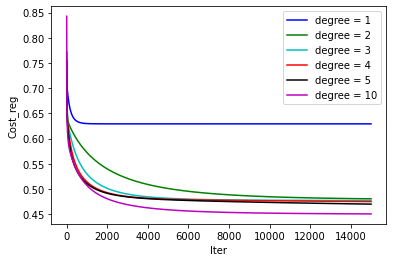

In [224]:
colour = ['b','g','c','r','k','m']
for i in range(len(colour)):
    plt.plot(iterations_history,cost_reg_history[i], color=colour[i], label='degree = {}'.format(degree_lst[i]))
plt.ylabel("Cost_reg"), plt.xlabel("Iter")
plt.legend()

Curiously, degree = 2 struggled to converge, however, as the code is vectorised we can do 15000 iterations quite quickly.

### Reducing cost with higher order features

Lets see if we can get a better model for our data by using higher degree features.

In [227]:
degree_vec = [1,2,3,4,5,6,7,8,9,10]
train_cost_vec, test_cost_vec = [], []
for degree_val in degree_vec:
    if degree_val==1:alpha_val = 0.3
    else:alpha_val = 3
    dummy_y_hat, dummy_W, dummy_b, train_cost, test_cost = logistic_regression(X_train, X_test, y_train, y_test, lambda_=0., alpha=alpha_val, degree = degree_val, max_iter=15000, print_step=False)
    train_cost_vec.append(train_cost)
    test_cost_vec.append(test_cost)
    print("Degree: {} complete".format(degree_val))

Degree: 1 complete
Degree: 2 complete
Degree: 3 complete
Degree: 4 complete
Degree: 5 complete
Degree: 6 complete
Degree: 7 complete
Degree: 8 complete
Degree: 9 complete
Degree: 10 complete


Note that we get calculation problems for degree>4. This is because the inputs to our leg functions get too close to zero.

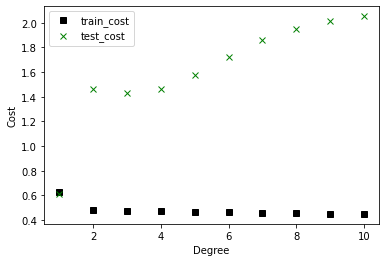

In [228]:
plt.plot(degree_vec,train_cost_vec, 'ks', label='train_cost')
plt.plot(degree_vec,test_cost_vec, 'gx', label='test_cost')
plt.ylabel("Cost"), plt.xlabel("Degree")
plt.legend()

We see that in this case polynomial features can significantly improve cost of the training set. However, they overfit the data meaning they reduce the test cost.

# Overfitting and reparameterisation

We see that the best model was for degree = 3. As the degree was increased beyond degree = 3 our model overfit to the training data, increasing the cost of the test dataset. To counter this we can use reparameterisation to punish the model for picking parge coefficients for our model. Lets see if we can improve the test cost for degree = 5 by reducing overfitting. 

In [229]:
lambda_vec = [0.01,0.1,0.17,0.3,0.67,1, 3]
#degree_vec = np.arange(20,23)
train_cost_vec, test_cost_vec = [], []
for lambda_val in lambda_vec:
    dummy_y_hat, dummy_W, dummy_b, train_cost, test_cost = logistic_regression(X_train, X_test, y_train, y_test, lambda_=lambda_val, alpha=3, degree = degree_val, max_iter=15000, print_step=False)
    train_cost_vec.append(train_cost)
    test_cost_vec.append(test_cost)
    print("lambda: {} complete".format(lambda_val))

lambda: 0.01 complete
lambda: 0.1 complete
lambda: 0.17 complete
lambda: 0.3 complete
lambda: 0.67 complete
lambda: 1 complete
lambda: 3 complete


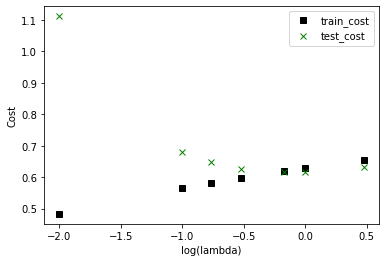

In [230]:
plt.plot(np.log10(lambda_vec),train_cost_vec, 'ks', label='train_cost')
plt.plot(np.log10(lambda_vec),test_cost_vec, 'gx', label='test_cost')
plt.ylabel("Cost"), plt.xlabel("log(lambda)")
plt.legend()

We can see that we reduced the test cost by selecting lambda_ = 0.3! Here we used reparameterisation to prevent overfitting the training data, whilst still improving the fit with higher powers of features. We see now we got a test cost of ~0.58 as opposed to our previous best of about 0.62. This is proof of working reparameterisation.